In [1]:
import pandas
import datetime
import urllib
import bs4
import os
import numpy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib import ticker
import seaborn as sns
import scipy
import feather
%matplotlib inline

In [2]:
rel_perc_cutoff = 0.15

In [3]:
finBndDF = feather.read_dataframe('../data/trghBndDst-fits.feather')
# There is 24 MLT and 0 MLT, remove the discrepancy
finBndDF["mlt"] = finBndDF["mlt"]%24
finBndDF = finBndDF.drop_duplicates()
finBndDF["dst_bin"] = finBndDF["dst_bin"].astype(str)
# Discard MLTs(for each dst_bin) where num observations are low
cntNMltDstPnts = finBndDF.groupby(["dst_bin", "normMLT"]).size().reset_index()
cntNMltDstPnts.columns = ["dst_bin", "normMLT", "cnt"]

cntMaxPnts = cntNMltDstPnts[ ["dst_bin", "cnt"] ].groupby("dst_bin").max().reset_index()
cntMaxPnts.columns = ["dst_bin", "max_cnt"]

cntNMltDstPnts = pandas.merge( cntNMltDstPnts, cntMaxPnts, on=["dst_bin"] )
cntNMltDstPnts["rel_perc"] = cntNMltDstPnts["cnt"]/cntNMltDstPnts["max_cnt"]
cntNMltDstPnts = cntNMltDstPnts[ cntNMltDstPnts["rel_perc"] > rel_perc_cutoff ].reset_index(drop=True)
cntNMltDstPnts = cntNMltDstPnts[ [ "dst_bin", "normMLT", "rel_perc" ] ]
# discard trghMean locations where obse are low
finBndDF = pandas.merge( finBndDF, cntNMltDstPnts, on=["dst_bin", "normMLT"], how="inner" )
print finBndDF.shape


(204907, 21)


In [4]:
trghMeanDF = finBndDF.groupby( ["dst_bin", "normMLT", "mlt"] ).mean().reset_index()
trghMeanDF.columns = ['dst_bin', 'normMLT', 'mlt', 'mlatEqu_mean', 'tecEqu_mean', 'mlon_mean',
       'mlatPol_mean', 'tecPol_mean', 'mlatMin_mean', 'tecMin_mean', 'mlonAdjst_mean',
       'delTecEqu_mean', 'delTecPol_mean', 'delMlat_mean', 'timeStr_mean', 'dst_index_mean', 'rel_perc_mean']
trghStdDF = finBndDF.groupby( ["dst_bin", "normMLT", "mlt"] ).std().reset_index()
trghStdDF.columns = ['dst_bin', 'normMLT', 'mlt', 'mlatEqu_std', 'tecEqu_std', 'mlon_std',
       'mlatPol_std', 'tecPol_std', 'mlatMin_std', 'tecMin_std', 'mlonAdjst_std',
       'delTecEqu_std', 'delTecPol_std', 'delMlat_std', 'timeStr_std', 'dst_index_std', 'rel_perc_std']
trghMeanDF = pandas.merge( trghMeanDF, trghStdDF, on=["dst_bin", "normMLT", "mlt"] )
trghMeanDF = trghMeanDF.dropna().reset_index(drop=True)
trghMeanDF.head()

,dst_bin,normMLT,mlt,mlatEqu_mean,tecEqu_mean,mlon_mean,mlatPol_mean,tecPol_mean,mlatMin_mean,tecMin_mean,...,tecPol_std,mlatMin_std,tecMin_std,mlonAdjst_std,delTecEqu_std,delTecPol_std,delMlat_std,timeStr_std,dst_index_std,rel_perc_std
0,"(-10, 10]",-3.0,21.0,53.084679,5.767901,286.672706,67.495077,5.618078,60.610083,3.676802,...,2.378100,3.200915,1.988274,24.636639,1.278013,1.195792,3.588044,164.622063,4.945651,0.0
1,"(-10, 10]",-2.0,22.0,51.959556,5.883296,290.170805,66.891460,5.846426,59.726486,3.867457,...,2.393627,2.985771,2.055292,25.477006,1.209754,1.229347,3.585624,171.807591,4.919972,0.0
2,"(-10, 10]",-1.0,23.0,51.130012,5.723219,294.368718,66.236275,5.737998,58.911079,3.700376,...,2.252076,2.782342,1.952053,26.703592,1.145823,1.209036,3.318120,181.237999,5.066290,0.0
3,"(-10, 10]",0.0,0.0,50.737948,5.537713,297.961532,66.050317,5.475978,58.619786,3.356817,...,2.155382,2.668640,1.756130,26.175764,1.219754,1.269629,3.255666,177.784436,5.026143,0.0
4,"(-10, 10]",1.0,1.0,50.651217,5.466132,298.494051,65.997510,5.359034,58.565232,3.131758,...,2.039238,2.582442,1.609357,25.429303,1.257380,1.259982,3.039740,172.384114,5.075928,0.0


In [5]:
sapsDF = feather.read_dataframe('../data/processedSaps.feather')
selCols = [ "dateStr", "hour", "sapsLat", "sapsMLT", "sapsVel", "dst_index" ]
sapsDF = sapsDF[selCols]
print sapsDF.shape

(173913, 6)


In [6]:
finBndSapsDF = finBndDF[ ( finBndDF["dateStr"].isin( sapsDF["dateStr"].values ) ) &\
                   ( finBndDF["hour"].isin( sapsDF["hour"].values ) ) ]
print finBndSapsDF.shape

(62053, 21)


In [7]:
finBndNoSapsDF = finBndDF[ ( ~finBndDF["dateStr"].isin( sapsDF["dateStr"].values ) ) |\
                   ( ~finBndDF["hour"].isin( sapsDF["hour"].values ) ) ]
print finBndNoSapsDF.shape

(142854, 21)


In [8]:
trghMeanSapsDF = finBndSapsDF.groupby( ["dst_bin", "normMLT", "mlt"] ).mean().reset_index()
trghMeanSapsDF.columns = ['dst_bin', 'normMLT', 'mlt', 'mlatEqu_mean', 'tecEqu_mean', 'mlon_mean',
       'mlatPol_mean', 'tecPol_mean', 'mlatMin_mean', 'tecMin_mean', 'mlonAdjst_mean',
       'delTecEqu_mean', 'delTecPol_mean', 'delMlat_mean', 'timeStr_mean', 'dst_index_mean', 'rel_perc_mean']
trghStdSapsDF = finBndSapsDF.groupby( ["dst_bin", "normMLT", "mlt"] ).std().reset_index()
trghStdSapsDF.columns = ['dst_bin', 'normMLT', 'mlt', 'mlatEqu_std', 'tecEqu_std', 'mlon_std',
       'mlatPol_std', 'tecPol_std', 'mlatMin_std', 'tecMin_std', 'mlonAdjst_std',
       'delTecEqu_std', 'delTecPol_std', 'delMlat_std', 'timeStr_std', 'dst_index_std', 'rel_perc_std']
trghMeanSapsDF = pandas.merge( trghMeanSapsDF, trghStdSapsDF, on=["dst_bin", "normMLT", "mlt"] )
trghMeanSapsDF = trghMeanSapsDF.dropna().reset_index(drop=True)
trghMeanSapsDF.head()

,dst_bin,normMLT,mlt,mlatEqu_mean,tecEqu_mean,mlon_mean,mlatPol_mean,tecPol_mean,mlatMin_mean,tecMin_mean,...,tecPol_std,mlatMin_std,tecMin_std,mlonAdjst_std,delTecEqu_std,delTecPol_std,delMlat_std,timeStr_std,dst_index_std,rel_perc_std
0,"(-10, 10]",-3.0,21.0,53.638051,7.418097,278.482599,67.227378,7.011601,60.621810,4.679814,...,2.336367,3.156151,2.349228,24.901294,1.466144,1.213331,3.230059,173.607658,4.017708,0.0
1,"(-10, 10]",-2.0,22.0,51.728205,6.689487,286.846154,65.978205,6.679231,58.958974,4.257179,...,2.247053,2.931106,2.003620,25.908186,1.449893,1.269157,3.439230,185.056023,3.792652,0.0
2,"(-10, 10]",-1.0,23.0,51.071633,6.565616,296.553964,65.274117,6.723496,58.257880,4.106877,...,2.292248,2.532083,2.040552,29.030082,1.223799,1.295621,3.323978,201.758668,4.051198,0.0
3,"(-10, 10]",0.0,0.0,50.506202,6.310233,292.003101,64.920930,6.294496,57.873643,3.767209,...,2.401446,2.459037,1.971886,27.127255,1.283083,1.392499,3.276159,190.927755,4.044628,0.0
4,"(-10, 10]",1.0,1.0,50.031951,6.045819,294.849762,64.685928,5.993066,57.488783,3.544663,...,2.301255,2.479517,1.817065,25.909189,1.243888,1.288514,2.866043,179.855952,3.847960,0.0


In [9]:
trghMeanNoSapsDF = finBndNoSapsDF.groupby( ["dst_bin", "normMLT", "mlt"] ).mean().reset_index()
trghMeanNoSapsDF.columns = ['dst_bin', 'normMLT', 'mlt', 'mlatEqu_mean', 'tecEqu_mean', 'mlon_mean',
       'mlatPol_mean', 'tecPol_mean', 'mlatMin_mean', 'tecMin_mean', 'mlonAdjst_mean',
       'delTecEqu_mean', 'delTecPol_mean', 'delMlat_mean', 'timeStr_mean', 'dst_index_mean', 'rel_perc_mean']
trghStdNoSapsDF = finBndNoSapsDF.groupby( ["dst_bin", "normMLT", "mlt"] ).std().reset_index()
trghStdNoSapsDF.columns = ['dst_bin', 'normMLT', 'mlt', 'mlatEqu_std', 'tecEqu_std', 'mlon_std',
       'mlatPol_std', 'tecPol_std', 'mlatMin_std', 'tecMin_std', 'mlonAdjst_std',
       'delTecEqu_std', 'delTecPol_std', 'delMlat_std', 'timeStr_std', 'dst_index_std', 'rel_perc_std']
trghMeanNoSapsDF = pandas.merge( trghMeanNoSapsDF, trghStdNoSapsDF, on=["dst_bin", "normMLT", "mlt"] )
trghMeanNoSapsDF = trghMeanNoSapsDF.dropna().reset_index(drop=True)
trghMeanNoSapsDF.head()

,dst_bin,normMLT,mlt,mlatEqu_mean,tecEqu_mean,mlon_mean,mlatPol_mean,tecPol_mean,mlatMin_mean,tecMin_mean,...,tecPol_std,mlatMin_std,tecMin_std,mlonAdjst_std,delTecEqu_std,delTecPol_std,delMlat_std,timeStr_std,dst_index_std,rel_perc_std
0,"(-10, 10]",-3.0,21.0,52.971537,5.430503,288.347249,67.549810,5.333159,60.607685,3.471727,...,2.284677,3.210726,1.840577,24.526387,1.193959,1.176606,3.634858,162.031611,5.070368,0.0
1,"(-10, 10]",-2.0,22.0,51.999339,5.744665,290.742504,67.048501,5.703219,59.858466,3.800441,...,2.389090,2.975502,2.056834,25.317277,1.148545,1.206221,3.597562,168.519071,5.025305,0.0
2,"(-10, 10]",-1.0,23.0,51.137647,5.613053,294.082938,66.362103,5.609118,58.996503,3.647215,...,2.214720,2.802335,1.934006,26.381133,1.122866,1.176449,3.299303,178.283496,5.140747,0.0
3,"(-10, 10]",0.0,0.0,50.765047,5.447380,298.658267,66.182379,5.380266,58.707034,3.308829,...,2.104176,2.678648,1.722871,26.060603,1.205108,1.245844,3.237195,176.078934,5.081214,0.0
4,"(-10, 10]",1.0,1.0,50.721371,5.400462,298.906893,66.146092,5.287208,58.687178,3.084983,...,1.994831,2.565610,1.577387,25.365340,1.257552,1.254304,3.049002,171.307484,5.130479,0.0


In [10]:
def format_mlt_normMLT_ticks(tick_val, tick_pos):
    if tick_val < 0:
        return str(tick_val + 24)
    else:
        return str(tick_val)

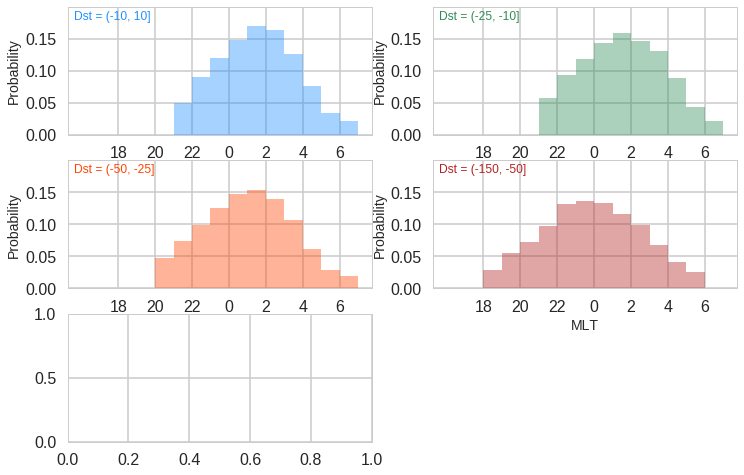

In [11]:
bins = range(-8,8,1)
colDict = {}
colDict['(-10, 10]'] = 'dodgerblue'
colDict['(-25, -10]'] = 'seagreen'
colDict['(-50, -25]'] = 'orangered'
colDict['(-150, -50]'] = 'firebrick'

sns.set_style("whitegrid")
sns.set_context("poster")

f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(3,2,1) )
axArr.append( f.add_subplot(3,2,2) )
axArr.append( f.add_subplot(3,2,3) )
axArr.append( f.add_subplot(3,2,4) )
axArr.append( f.add_subplot(3,2,5) )

dstBinArrSorted = ['(-10, 10]', '(-25, -10]', '(-50, -25]', '(-150, -50]']
for binInd, currDstBin in enumerate(dstBinArrSorted):
    selDF = finBndSapsDF[ finBndSapsDF["dst_bin"] == currDstBin]
#     sns.distplot(selDF["normMLT"].values, bins=bins, kde=False,\
#                  hist=True, fit=scipy.stats.gennorm,\
#                  fit_kws={"color": colDict[currDstBin]},\
#                  hist_kws={"color": colDict[currDstBin]}, ax=axArr[binInd])
    sns.distplot(selDF["normMLT"].values, bins=bins, kde=False,\
                 hist=True,norm_hist=True,\
                 fit_kws={"color": colDict[currDstBin]},\
                 hist_kws={"color": colDict[currDstBin]}, ax=axArr[binInd])
#     break
    axArr[binInd].set_xlabel("MLT", fontsize=14)
    axArr[binInd].set_ylabel("Probability", fontsize=14)
    axArr[binInd].set_xticks( range(-6,7,2) )
    axArr[binInd].set_ylim([0,0.2])
    axArr[binInd].set_yticks( numpy.arange(0,0.2,0.05) )
    axArr[binInd].xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks)) 
    axArr[binInd].text(0.02, 0.9,  "Dst = " + currDstBin,
            transform=axArr[binInd].transAxes,
            color=colDict[currDstBin], fontsize=12)
plt.savefig("../figs/allBinsHist-saps.pdf",bbox_inches='tight')

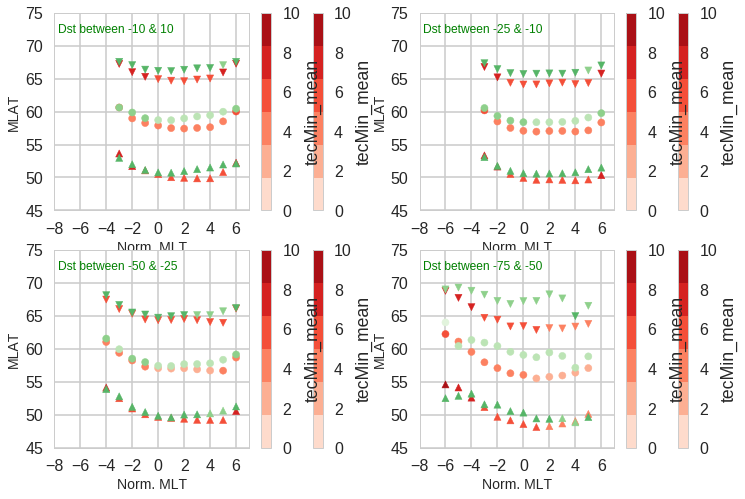

In [12]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
sns.set_style("whitegrid")
sns.set_context("poster")

f = plt.figure(figsize=(12, 8))
ax4 = f.add_subplot(2,2,1)
ax3 = f.add_subplot(2,2,2)
ax2 = f.add_subplot(2,2,3)
ax1 = f.add_subplot(2,2,4)


vmin=0.
vmax=10.
xlim = [-8, 7]
ylim = [ 45, 75 ]
xticksList = range(xlim[0],xlim[1]+1, 2)

seaMapSaps = ListedColormap(sns.color_palette("Reds"))
seaMap = ListedColormap(sns.color_palette("Greens"))



# (-75, -50]
trghSel7550 = trghMeanSapsDF[ trghMeanSapsDF["dst_bin"] == "(-150, -50]" ]
trghSel7550.plot( kind='scatter',
              x='normMLT',
              y='mlatMin_mean',
              c='tecMin_mean',
              s=50, cmap=seaMapSaps, vmin=vmin, vmax=vmax, ax=ax1)
trghSel7550.plot( kind='scatter',
              x='normMLT',
              y='mlatEqu_mean',
              c='tecEqu_mean',
              s=50, marker='^', cmap=seaMapSaps, vmin=vmin, vmax=vmax, ax=ax1,colorbar=False)
trghSel7550.plot( kind='scatter',
              x='normMLT',
              y='mlatPol_mean',
              c='tecPol_mean',
              s=50, marker='v', cmap=seaMapSaps, vmin=vmin, vmax=vmax, ax=ax1,colorbar=False)
trghSel7550 = trghMeanNoSapsDF[ trghMeanNoSapsDF["dst_bin"] == "(-150, -50]" ]
trghSel7550.plot( kind='scatter',
              x='normMLT',
              y='mlatMin_mean',
              c='tecMin_mean',
              s=50, cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax1)
trghSel7550.plot( kind='scatter',
              x='normMLT',
              y='mlatEqu_mean',
              c='tecEqu_mean',
              s=50, marker='^', cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax1,colorbar=False)
trghSel7550.plot( kind='scatter',
              x='normMLT',
              y='mlatPol_mean',
              c='tecPol_mean',
              s=50, marker='v', cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax1,colorbar=False)
ax1.set_ylabel("MLAT", fontsize=14)
ax1.set_xlabel("Norm. MLT", fontsize=14)
# ax1.set_title( "Dst between -75 & -50", fontsize=14 )
ax1.text(0.02, 0.9,  "Dst between -75 & -50",
            transform=ax1.transAxes,
            color="green", fontsize=12)
ax1.set_xlim( xlim )
ax1.set_ylim( ylim )
ax1.set_xticks(xticksList)
# (-50, -25]
trghSel5025 = trghMeanSapsDF[ trghMeanSapsDF["dst_bin"] == "(-50, -25]" ]
trghSel5025.plot( kind='scatter',
              x='normMLT',
              y='mlatMin_mean',
              c='tecMin_mean',
              s=50, cmap=seaMapSaps, vmin=vmin, vmax=vmax, ax=ax2)
trghSel5025.plot( kind='scatter',
              x='normMLT',
              y='mlatEqu_mean',
              c='tecEqu_mean',
              s=50, marker='^', cmap=seaMapSaps, vmin=vmin, vmax=vmax, ax=ax2,colorbar=False)
trghSel5025.plot( kind='scatter',
              x='normMLT',
              y='mlatPol_mean',
              c='tecPol_mean',
              s=50, marker='v', cmap=seaMapSaps, vmin=vmin, vmax=vmax, ax=ax2,colorbar=False)
trghSel5025 = trghMeanNoSapsDF[ trghMeanNoSapsDF["dst_bin"] == "(-50, -25]" ]
trghSel5025.plot( kind='scatter',
              x='normMLT',
              y='mlatMin_mean',
              c='tecMin_mean',
              s=50, cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax2)
trghSel5025.plot( kind='scatter',
              x='normMLT',
              y='mlatEqu_mean',
              c='tecEqu_mean',
              s=50, marker='^', cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax2,colorbar=False)
trghSel5025.plot( kind='scatter',
              x='normMLT',
              y='mlatPol_mean',
              c='tecPol_mean',
              s=50, marker='v', cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax2,colorbar=False)
ax2.set_ylabel("MLAT", fontsize=14)
ax2.set_xlabel("Norm. MLT", fontsize=14)
# ax2.set_title( "Dst between -50 & -25", fontsize=14 )
ax2.text(0.02, 0.9,  "Dst between -50 & -25",
            transform=ax2.transAxes,
            color="green", fontsize=12)
ax2.set_xlim( xlim )
ax2.set_ylim( ylim )
ax2.set_xticks(xticksList)
# (-25, -10]
trghSel2510 = trghMeanSapsDF[ trghMeanSapsDF["dst_bin"] == "(-25, -10]" ]
trghSel2510.plot( kind='scatter',
              x='normMLT',
              y='mlatMin_mean',
              c='tecMin_mean',
              s=50, cmap=seaMapSaps, vmin=vmin, vmax=vmax, ax=ax3)
trghSel2510.plot( kind='scatter',
              x='normMLT',
              y='mlatEqu_mean',
              c='tecEqu_mean',
              s=50, marker='^', cmap=seaMapSaps, vmin=vmin, vmax=vmax, ax=ax3,colorbar=False)
trghSel2510.plot( kind='scatter',
              x='normMLT',
              y='mlatPol_mean',
              c='tecPol_mean',
              s=50, marker='v', cmap=seaMapSaps, vmin=vmin, vmax=vmax, ax=ax3,colorbar=False)
trghSel2510 = trghMeanNoSapsDF[ trghMeanNoSapsDF["dst_bin"] == "(-25, -10]" ]
trghSel2510.plot( kind='scatter',
              x='normMLT',
              y='mlatMin_mean',
              c='tecMin_mean',
              s=50, cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax3)
trghSel2510.plot( kind='scatter',
              x='normMLT',
              y='mlatEqu_mean',
              c='tecEqu_mean',
              s=50, marker='^', cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax3,colorbar=False)
trghSel2510.plot( kind='scatter',
              x='normMLT',
              y='mlatPol_mean',
              c='tecPol_mean',
              s=50, marker='v', cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax3,colorbar=False)
ax3.set_ylabel("MLAT", fontsize=14)
ax3.set_xlabel("Norm. MLT", fontsize=14)
# ax3.set_title( "Dst between -25 & -10", fontsize=14 )
ax3.text(0.02, 0.9,  "Dst between -25 & -10",
            transform=ax3.transAxes,
            color="green", fontsize=12)
ax3.set_xlim( xlim )
ax3.set_ylim( ylim )
ax3.set_xticks(xticksList)
# (-10, 10]
trghSel1010 = trghMeanSapsDF[ trghMeanSapsDF["dst_bin"] == "(-10, 10]" ]
trghSel1010.plot( kind='scatter',
              x='normMLT',
              y='mlatMin_mean',
              c='tecMin_mean',
              s=50, cmap=seaMapSaps, vmin=vmin, vmax=vmax, ax=ax4)
trghSel1010.plot( kind='scatter',
              x='normMLT',
              y='mlatEqu_mean',
              c='tecEqu_mean',
              s=50, marker='^', cmap=seaMapSaps, vmin=vmin, vmax=vmax, ax=ax4,colorbar=False)
trghSel1010.plot( kind='scatter',
              x='normMLT',
              y='mlatPol_mean',
              c='tecPol_mean',
              s=50, marker='v', cmap=seaMapSaps, vmin=vmin, vmax=vmax, ax=ax4,colorbar=False)
trghSel1010 = trghMeanNoSapsDF[ trghMeanNoSapsDF["dst_bin"] == "(-10, 10]" ]
trghSel1010.plot( kind='scatter',
              x='normMLT',
              y='mlatMin_mean',
              c='tecMin_mean',
              s=50, cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax4)
trghSel1010.plot( kind='scatter',
              x='normMLT',
              y='mlatEqu_mean',
              c='tecEqu_mean',
              s=50, marker='^', cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax4,colorbar=False)
trghSel1010.plot( kind='scatter',
              x='normMLT',
              y='mlatPol_mean',
              c='tecPol_mean',
              s=50, marker='v', cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax4,colorbar=False)
ax4.set_ylabel("MLAT", fontsize=14)
ax4.set_xlabel("Norm. MLT", fontsize=14)
# ax4.set_title( "Dst between -10 & 10", fontsize=14 )
ax4.text(0.02, 0.9,  "Dst between -10 & 10",
            transform=ax4.transAxes,
            color="green", fontsize=12)
ax4.set_xlim( xlim )
ax4.set_ylim( ylim )
ax4.set_xticks(xticksList)
plt.savefig("../figs/allBinsTrghLoc-saps.pdf",bbox_inches='tight')

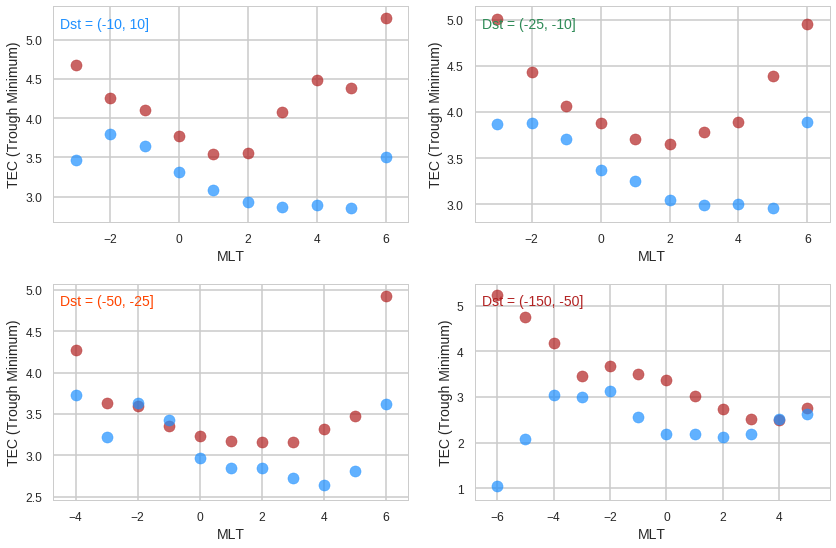

In [13]:
dstBinArrSorted = ['(-10, 10]', '(-25, -10]', '(-50, -25]', '(-150, -50]']

bins = numpy.arange(50,70,1)

f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(2,2,1) )
axArr.append( f.add_subplot(2,2,2) )
axArr.append( f.add_subplot(2,2,3) )
axArr.append( f.add_subplot(2,2,4) )

for dstInd, currDst in enumerate(dstBinArrSorted):
    currSapsDF = trghMeanSapsDF[ trghMeanSapsDF["dst_bin"] == currDst ]
    currAllDF = trghMeanNoSapsDF[ trghMeanSapsDF["dst_bin"] == currDst ]
    
    axArr[dstInd].scatter(currSapsDF['normMLT'],
            currSapsDF['tecMin_mean'],
            marker='o',
            color="firebrick",
            alpha=0.7,
            s = 124,
            label='SAPS TIME')
    axArr[dstInd].scatter(currAllDF['normMLT'],
            currAllDF['tecMin_mean'],
            marker='o',
            color="dodgerblue",
            alpha=0.7,
            s = 124,
            label='NON SAPS TIME')

    axArr[dstInd].text(0.02, 0.9,  "Dst = " + currDst,
            transform=axArr[dstInd].transAxes,
            color=colDict[currDst], fontsize=14)
    axArr[dstInd].set_xlabel("MLT", fontsize=14)
    axArr[dstInd].set_ylabel("TEC (Trough Minimum)", fontsize=14)
    axArr[dstInd].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("../figs/trghMin-TEC-compr.eps",bbox_inches='tight')

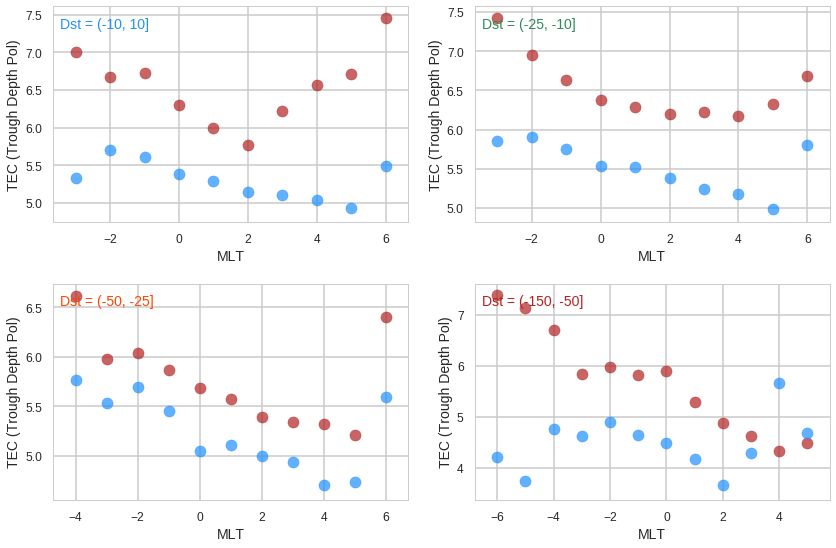

In [14]:
dstBinArrSorted = ['(-10, 10]', '(-25, -10]', '(-50, -25]', '(-150, -50]']

bins = numpy.arange(50,70,1)

f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(2,2,1) )
axArr.append( f.add_subplot(2,2,2) )
axArr.append( f.add_subplot(2,2,3) )
axArr.append( f.add_subplot(2,2,4) )

for dstInd, currDst in enumerate(dstBinArrSorted):
    currSapsDF = trghMeanSapsDF[ trghMeanSapsDF["dst_bin"] == currDst ]
    currAllDF = trghMeanNoSapsDF[ trghMeanSapsDF["dst_bin"] == currDst ]
    
    axArr[dstInd].scatter(currSapsDF['normMLT'],
            currSapsDF['tecPol_mean'],
            marker='o',
            color="firebrick",
            alpha=0.7,
            s = 124,
            label='SAPS TIME')
    axArr[dstInd].scatter(currAllDF['normMLT'],
            currAllDF['tecPol_mean'],
            marker='o',
            color="dodgerblue",
            alpha=0.7,
            s = 124,
            label='NON SAPS TIME')

    axArr[dstInd].text(0.02, 0.9,  "Dst = " + currDst,
            transform=axArr[dstInd].transAxes,
            color=colDict[currDst], fontsize=14)
    axArr[dstInd].set_xlabel("MLT", fontsize=14)
    axArr[dstInd].set_ylabel("TEC (Trough Depth Pol)", fontsize=14)
    axArr[dstInd].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("../figs/trghDepPol-TEC-compr.eps",bbox_inches='tight')

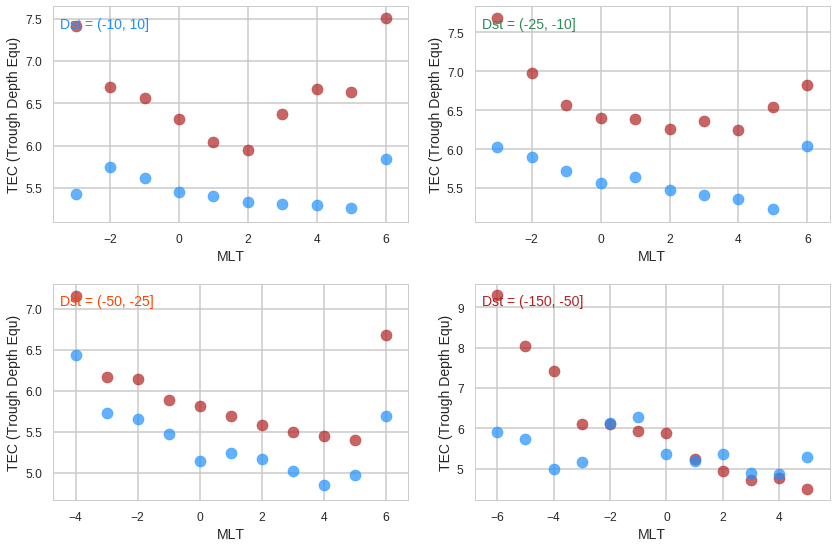

In [15]:
dstBinArrSorted = ['(-10, 10]', '(-25, -10]', '(-50, -25]', '(-150, -50]']

bins = numpy.arange(50,70,1)

f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(2,2,1) )
axArr.append( f.add_subplot(2,2,2) )
axArr.append( f.add_subplot(2,2,3) )
axArr.append( f.add_subplot(2,2,4) )

for dstInd, currDst in enumerate(dstBinArrSorted):
    currSapsDF = trghMeanSapsDF[ trghMeanSapsDF["dst_bin"] == currDst ]
    currAllDF = trghMeanNoSapsDF[ trghMeanSapsDF["dst_bin"] == currDst ]
    
    axArr[dstInd].scatter(currSapsDF['normMLT'],
            currSapsDF['tecEqu_mean'],
            marker='o',
            color="firebrick",
            alpha=0.7,
            s = 124,
            label='SAPS TIME')
    axArr[dstInd].scatter(currAllDF['normMLT'],
            currAllDF['tecEqu_mean'],
            marker='o',
            color="dodgerblue",
            alpha=0.7,
            s = 124,
            label='NON SAPS TIME')

    axArr[dstInd].text(0.02, 0.9,  "Dst = " + currDst,
            transform=axArr[dstInd].transAxes,
            color=colDict[currDst], fontsize=14)
    axArr[dstInd].set_xlabel("MLT", fontsize=14)
    axArr[dstInd].set_ylabel("TEC (Trough Depth Equ)", fontsize=14)
    axArr[dstInd].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("../figs/trghDepEqu-TEC-compr.eps",bbox_inches='tight')

In [16]:
# Here we'll compare SAPS mean location with TEC Boundaries and Min loc!!!
sapsProbFileName = "../data/sapsProbs.txt"
sapsProbDF = pandas.read_csv(sapsProbFileName, sep=' ')
# Discard rows where prob of occ is less than 0.2
sapsProbDF = sapsProbDF[ sapsProbDF["probOcc"] >= 0.15 ].reset_index(drop=True)
sapsProbDF.head()

,dst_bin,sapsMLT,sapsLat,normMLT,normLAT,dataCount,maxCount,MLT,probOcc
0,"(-150, -75]",0.0,55.5,0.0,-2.0,50,333,0,0.150150
1,"(-150, -75]",1.0,54.5,1.0,-3.0,74,333,1,0.222222
2,"(-150, -75]",1.0,55.5,1.0,-2.0,80,333,1,0.240240
3,"(-150, -75]",1.0,56.5,1.0,-1.0,82,333,1,0.246246
4,"(-150, -75]",1.0,57.5,1.0,0.0,50,333,1,0.150150


In [17]:
# # Make a comparison plot of the data
# # for prob of occ at diff locs
# # Set up the matplotlib figure
# f = plt.figure(figsize=(12, 8))
# ax1 = f.add_subplot(3,2,1)
# ax2 = f.add_subplot(3,2,2)
# ax3 = f.add_subplot(3,2,3)
# ax4 = f.add_subplot(3,2,4)
# ax5 = f.add_subplot(3,2,5)


# sns.set_style("darkgrid")
# sns.set_context("paper")
# seaMap = ListedColormap(sns.color_palette("Blues"))
# sapsSeaMap = ListedColormap(sns.color_palette("Reds"))
# # (-150,-75]
# # trghMLTLat15075 = trghMeanNoSapsDF[ trghMeanNoSapsDF["dst_bin"] == "(-150, -75]" ]
# # trghMLTLat15075.plot( kind='scatter',
# #               x='normMLT',
# #               y='mlatMin_mean',
# #               c='tecMin_mean', marker='*',
# #               s=100, cmap=seaMap, ax=ax1, vmin=2., vmax=10., sharex=True, colorbar=False)
# # trghMLTLat15075.plot( kind='scatter',
# #               x='normMLT',
# #               y='mlatEqu_mean',
# #               c='tecEqu_mean',
# #               s=100, cmap=seaMap, marker='^', ax=ax1, vmin=2., vmax=10., colorbar=False)
# # trghMLTLat15075.plot( kind='scatter',
# #               x='normMLT',
# #               y='mlatPol_mean',
# #               c='tecPol_mean',
# #               s=100, cmap=seaMap, marker='v', ax=ax1, vmin=2., vmax=10., colorbar=False)
# # sapsProbDF15075 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-150, -75]" ]
# # sapsProbDF15075.plot( kind='scatter',
# #               x='normMLT',
# #               y='sapsLat',
# #               c='probOcc',
# #               s=sapsProbDF15075["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax1, colorbar=False)

# ax1.set_ylabel("Lat", fontsize=14)
# ax1.set_xlabel("NormMLT", fontsize=14)
# ax1.set_title( "Dst between -150 & -75", fontsize=14 )
# ax1.set_xlim( [-9,6] )
# ax1.set_ylim( [45,70] )

# # (-75, -50]
# trghMLTLat7550 = trghMeanNoSapsDF[ trghMeanNoSapsDF["dst_bin"] == "(-75, -50]" ]
# trghMLTLat7550.plot( kind='scatter',
#               x='normMLT',
#               y='mlatMin_mean',
#               c='tecMin_mean',marker='*',
#               s=100, cmap=seaMap, ax=ax2, vmin=2., vmax=10., colorbar=False)
# trghMLTLat7550.plot( kind='scatter',
#               x='normMLT',
#               y='mlatEqu_mean',
#               c='tecEqu_mean',
#               s=100, cmap=seaMap, marker='^', ax=ax2, vmin=2., vmax=10., colorbar=False)
# trghMLTLat7550.plot( kind='scatter',
#               x='normMLT',
#               y='mlatPol_mean',
#               c='tecPol_mean',
#               s=100, cmap=seaMap, marker='v', ax=ax2, vmin=2., vmax=10., colorbar=False)
# sapsProbDF7550 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-75, -50]" ]
# sapsProbDF7550.plot( kind='scatter',
#               x='normMLT',
#               y='sapsLat',
#               c='probOcc',
#               s=sapsProbDF7550["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax2, colorbar=False)
# ax2.set_ylabel("Lat", fontsize=14)
# ax2.set_xlabel("NormMLT", fontsize=14)
# ax2.set_title( "Dst between -75 & -50", fontsize=14 )
# ax2.set_xlim( [-9,6] )
# ax2.set_ylim( [45,70] )
# # (-50, -25]
# trghMLTLat5025 = trghMeanNoSapsDF[ trghMeanNoSapsDF["dst_bin"] == "(-50, -25]" ]
# trghMLTLat5025.plot( kind='scatter',
#               x='normMLT',
#               y='mlatMin_mean',
#               c='tecMin_mean',marker='*',
#               s=100, cmap=seaMap, ax=ax3, vmin=2., vmax=10., colorbar=False)
# trghMLTLat5025.plot( kind='scatter',
#               x='normMLT',
#               y='mlatEqu_mean',
#               c='tecEqu_mean',
#               s=100, cmap=seaMap, marker='^', ax=ax3, vmin=2., vmax=10., colorbar=False)
# trghMLTLat5025.plot( kind='scatter',
#               x='normMLT',
#               y='mlatPol_mean',
#               c='tecPol_mean',
#               s=100, cmap=seaMap, marker='v', ax=ax3, vmin=2., vmax=10., colorbar=False)
# sapsProbDF5025 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-50, -25]" ]
# sapsProbDF5025.plot( kind='scatter',
#               x='normMLT',
#               y='sapsLat',
#               c='probOcc',
#               s=sapsProbDF5025["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax3, colorbar=False)
# ax3.set_ylabel("Lat", fontsize=14)
# ax3.set_xlabel("NormMLT", fontsize=14)
# ax3.set_title( "Dst between -50 & -25", fontsize=14 )
# ax3.set_xlim( [-9,6] )
# ax3.set_ylim( [45,70] )
# # (-25, -10]
# trghMLTLat2510 = trghMeanNoSapsDF[ trghMeanNoSapsDF["dst_bin"] == "(-25, -10]" ]
# trghMLTLat2510.plot( kind='scatter',
#               x='normMLT',
#               y='mlatMin_mean',
#               c='tecMin_mean',marker='*',
#               s=100, cmap=seaMap, ax=ax4, vmin=2., vmax=10., colorbar=False)
# trghMLTLat2510.plot( kind='scatter',
#               x='normMLT',
#               y='mlatEqu_mean',
#               c='tecEqu_mean',
#               s=100, cmap=seaMap, marker='^', ax=ax4, vmin=2., vmax=10., colorbar=False)
# trghMLTLat2510.plot( kind='scatter',
#               x='normMLT',
#               y='mlatPol_mean',
#               c='tecPol_mean',
#               s=100, cmap=seaMap, marker='v', ax=ax4, vmin=2., vmax=10., colorbar=False)
# sapsProbDF2510 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-25, -10]" ]
# sapsProbDF2510.plot( kind='scatter',
#               x='normMLT',
#               y='sapsLat',
#               c='probOcc',
#               s=sapsProbDF2510["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax4, colorbar=False)
# ax4.set_ylabel("Lat", fontsize=14)
# ax4.set_xlabel("NormMLT", fontsize=14)
# ax4.set_title( "Dst between -25 & -10", fontsize=14 )
# ax4.set_xlim( [-9,6] )
# ax4.set_ylim( [45,70] )
# # (-10, 10]
# trghMLTLat1010 = trghMeanNoSapsDF[ trghMeanNoSapsDF["dst_bin"] == "(-10, 10]" ]
# trghMLTLat1010.plot( kind='scatter',
#               x='normMLT',
#               y='mlatMin_mean',
#               c='tecMin_mean',marker='*',
#               s=100, cmap=seaMap, ax=ax5, vmin=2., vmax=10., colorbar=False)
# trghMLTLat1010.plot( kind='scatter',
#               x='normMLT',
#               y='mlatEqu_mean',
#               c='tecEqu_mean',
#               s=100, cmap=seaMap, marker='^', ax=ax5, vmin=2., vmax=10., colorbar=False)
# trghMLTLat1010.plot( kind='scatter',
#               x='normMLT',
#               y='mlatPol_mean',
#               c='tecPol_mean',
#               s=100, cmap=seaMap, marker='v', ax=ax5, vmin=2., vmax=10., colorbar=False)
# sapsProbDF1010 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-10, 10]" ]
# sapsProbDF1010.plot( kind='scatter',
#               x='normMLT',
#               y='sapsLat',
#               c='probOcc',
#               s=sapsProbDF1010["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax5, colorbar=False)
# ax5.set_ylabel("Lat", fontsize=14)
# ax5.set_xlabel("NormMLT", fontsize=14)
# ax5.set_title( "Dst between -10 & 10", fontsize=14 )
# ax5.set_xlim( [-9,6] )
# ax5.set_ylim( [45,70] )

# plt.savefig("../figs/AlltrghBnds-SAPS.pdf",bbox_inches='tight')

In [18]:
# # Make a comparison plot of the data
# # for prob of occ at diff locs
# # Set up the matplotlib figure
# f = plt.figure(figsize=(12, 8))
# ax1 = f.add_subplot(3,2,1)
# ax2 = f.add_subplot(3,2,2)
# ax3 = f.add_subplot(3,2,3)
# ax4 = f.add_subplot(3,2,4)
# ax5 = f.add_subplot(3,2,5)


# sns.set_style("whitegrid")
# sns.set_context("paper")
# seaMap = ListedColormap(sns.color_palette("Blues"))
# sapsSeaMap = ListedColormap(sns.color_palette("Reds"))
# # (-150,-75]
# trghMLTLat15075 = trghMeanSapsDF[ trghMeanSapsDF["dst_bin"] == "(-150, -75]" ]
# trghMLTLat15075.plot( kind='scatter',
#               x='normMLT',
#               y='mlatMin_mean',
#               c='tecMin_mean', marker='*',
#               s=100, cmap=seaMap, ax=ax1, vmin=2., vmax=10., sharex=True, colorbar=False)
# trghMLTLat15075.plot( kind='scatter',
#               x='normMLT',
#               y='mlatEqu_mean',
#               c='tecEqu_mean',
#               s=100, cmap=seaMap, marker='^', ax=ax1, vmin=2., vmax=10., colorbar=False)
# trghMLTLat15075.plot( kind='scatter',
#               x='normMLT',
#               y='mlatPol_mean',
#               c='tecPol_mean',
#               s=100, cmap=seaMap, marker='v', ax=ax1, vmin=2., vmax=10., colorbar=False)
# sapsProbDF15075 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-150, -75]" ]
# sapsProbDF15075.plot( kind='scatter',
#               x='normMLT',
#               y='sapsLat',
#               c='probOcc',
#               s=sapsProbDF15075["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax1, colorbar=False)

# ax1.set_ylabel("Lat", fontsize=14)
# ax1.set_xlabel("NormMLT", fontsize=14)
# ax1.set_title( "Dst between -150 & -75", fontsize=14 )
# ax1.set_xlim( [-9,6] )
# ax1.set_ylim( [45,70] )

# # (-75, -50]
# trghMLTLat7550 = trghMeanSapsDF[ trghMeanSapsDF["dst_bin"] == "(-75, -50]" ]
# trghMLTLat7550.plot( kind='scatter',
#               x='normMLT',
#               y='mlatMin_mean',
#               c='tecMin_mean',marker='*',
#               s=100, cmap=seaMap, ax=ax2, vmin=2., vmax=10., colorbar=False)
# trghMLTLat7550.plot( kind='scatter',
#               x='normMLT',
#               y='mlatEqu_mean',
#               c='tecEqu_mean',
#               s=100, cmap=seaMap, marker='^', ax=ax2, vmin=2., vmax=10., colorbar=False)
# trghMLTLat7550.plot( kind='scatter',
#               x='normMLT',
#               y='mlatPol_mean',
#               c='tecPol_mean',
#               s=100, cmap=seaMap, marker='v', ax=ax2, vmin=2., vmax=10., colorbar=False)
# sapsProbDF7550 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-75, -50]" ]
# sapsProbDF7550.plot( kind='scatter',
#               x='normMLT',
#               y='sapsLat',
#               c='probOcc',
#               s=sapsProbDF7550["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax2, colorbar=False)
# ax2.set_ylabel("Lat", fontsize=14)
# ax2.set_xlabel("NormMLT", fontsize=14)
# ax2.set_title( "Dst between -75 & -50", fontsize=14 )
# ax2.set_xlim( [-9,6] )
# ax2.set_ylim( [45,70] )
# # (-50, -25]
# trghMLTLat5025 = trghMeanSapsDF[ trghMeanSapsDF["dst_bin"] == "(-50, -25]" ]
# trghMLTLat5025.plot( kind='scatter',
#               x='normMLT',
#               y='mlatMin_mean',
#               c='tecMin_mean',marker='*',
#               s=100, cmap=seaMap, ax=ax3, vmin=2., vmax=10., colorbar=False)
# trghMLTLat5025.plot( kind='scatter',
#               x='normMLT',
#               y='mlatEqu_mean',
#               c='tecEqu_mean',
#               s=100, cmap=seaMap, marker='^', ax=ax3, vmin=2., vmax=10., colorbar=False)
# trghMLTLat5025.plot( kind='scatter',
#               x='normMLT',
#               y='mlatPol_mean',
#               c='tecPol_mean',
#               s=100, cmap=seaMap, marker='v', ax=ax3, vmin=2., vmax=10., colorbar=False)
# sapsProbDF5025 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-50, -25]" ]
# sapsProbDF5025.plot( kind='scatter',
#               x='normMLT',
#               y='sapsLat',
#               c='probOcc',
#               s=sapsProbDF5025["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax3, colorbar=False)
# ax3.set_ylabel("Lat", fontsize=14)
# ax3.set_xlabel("NormMLT", fontsize=14)
# ax3.set_title( "Dst between -50 & -25", fontsize=14 )
# ax3.set_xlim( [-9,6] )
# ax3.set_ylim( [45,70] )
# # (-25, -10]
# trghMLTLat2510 = trghMeanSapsDF[ trghMeanSapsDF["dst_bin"] == "(-25, -10]" ]
# trghMLTLat2510.plot( kind='scatter',
#               x='normMLT',
#               y='mlatMin_mean',
#               c='tecMin_mean',marker='*',
#               s=100, cmap=seaMap, ax=ax4, vmin=2., vmax=10., colorbar=False)
# trghMLTLat2510.plot( kind='scatter',
#               x='normMLT',
#               y='mlatEqu_mean',
#               c='tecEqu_mean',
#               s=100, cmap=seaMap, marker='^', ax=ax4, vmin=2., vmax=10., colorbar=False)
# trghMLTLat2510.plot( kind='scatter',
#               x='normMLT',
#               y='mlatPol_mean',
#               c='tecPol_mean',
#               s=100, cmap=seaMap, marker='v', ax=ax4, vmin=2., vmax=10., colorbar=False)
# sapsProbDF2510 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-25, -10]" ]
# sapsProbDF2510.plot( kind='scatter',
#               x='normMLT',
#               y='sapsLat',
#               c='probOcc',
#               s=sapsProbDF2510["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax4, colorbar=False)
# ax4.set_ylabel("Lat", fontsize=14)
# ax4.set_xlabel("NormMLT", fontsize=14)
# ax4.set_title( "Dst between -25 & -10", fontsize=14 )
# ax4.set_xlim( [-9,6] )
# ax4.set_ylim( [45,70] )
# # (-10, 10]
# trghMLTLat1010 = trghMeanSapsDF[ trghMeanSapsDF["dst_bin"] == "(-10, 10]" ]
# trghMLTLat1010.plot( kind='scatter',
#               x='normMLT',
#               y='mlatMin_mean',
#               c='tecMin_mean',marker='*',
#               s=100, cmap=seaMap, ax=ax5, vmin=2., vmax=10., colorbar=False)
# trghMLTLat1010.plot( kind='scatter',
#               x='normMLT',
#               y='mlatEqu_mean',
#               c='tecEqu_mean',
#               s=100, cmap=seaMap, marker='^', ax=ax5, vmin=2., vmax=10., colorbar=False)
# trghMLTLat1010.plot( kind='scatter',
#               x='normMLT',
#               y='mlatPol_mean',
#               c='tecPol_mean',
#               s=100, cmap=seaMap, marker='v', ax=ax5, vmin=2., vmax=10., colorbar=False)
# sapsProbDF1010 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-10, 10]" ]
# sapsProbDF1010.plot( kind='scatter',
#               x='normMLT',
#               y='sapsLat',
#               c='probOcc',
#               s=sapsProbDF1010["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax5, colorbar=False)
# ax5.set_ylabel("Lat", fontsize=14)
# ax5.set_xlabel("NormMLT", fontsize=14)
# ax5.set_title( "Dst between -10 & 10", fontsize=14 )
# ax5.set_xlim( [-9,6] )
# ax5.set_ylim( [45,70] )

# plt.savefig("../figs/SAPStrghBnds-SAPS.pdf",bbox_inches='tight')

In [19]:
dstBinSel = "(-10, 10]"
finBndNoSapsDFNoSaps = finBndNoSapsDF[ ~finBndNoSapsDF["dateStr"].isin( sapsDF["dateStr"].values ) ]
selDF = finBndNoSapsDFNoSaps[ finBndNoSapsDFNoSaps["dst_bin"] == dstBinSel ].groupby("date").size().sort_values(ascending=False)
print selDF.head(10)

date
2012-10-07 09:25:00    51
2013-03-26 10:25:00    51
2012-08-25 08:10:00    49
2011-10-06 10:40:00    47
2013-05-08 08:35:00    46
2013-04-18 09:45:00    45
2013-03-26 10:20:00    45
2012-08-13 08:50:00    44
2013-04-17 10:55:00    44
2013-04-17 10:10:00    44
dtype: int64


In [30]:
dstBinSel = "(-10, 10]"
finBndSapsDF["month"] = finBndSapsDF["date"].dt.month
selSapsDF = finBndSapsDF[ (finBndSapsDF["dst_bin"] == dstBinSel) &\
                        ( (finBndSapsDF["month"] > 9) | (finBndSapsDF["month"] < 3) )].groupby("date").size().sort_values(ascending=False)
print selSapsDF.head(50)

date
2012-02-26 09:30:00    38
2012-02-26 09:20:00    33
2012-02-26 08:40:00    32
2012-02-26 09:55:00    29
2012-02-26 09:00:00    28
2012-12-02 09:25:00    27
2012-01-21 10:40:00    27
2012-02-26 07:05:00    26
2012-12-02 09:30:00    25
2012-02-26 07:30:00    25
2012-12-02 09:45:00    24
2012-02-22 08:15:00    24
2012-01-21 06:45:00    24
2012-02-26 12:40:00    24
2012-02-26 12:35:00    23
2012-02-14 11:50:00    23
2012-02-26 08:45:00    22
2012-12-02 09:40:00    22
2012-10-23 09:25:00    22
2012-02-26 08:50:00    22
2012-02-26 08:10:00    21
2012-02-22 07:50:00    20
2012-02-04 07:15:00    20
2012-02-26 12:45:00    19
2012-10-24 04:30:00    19
2012-01-21 07:50:00    19
2012-12-02 09:35:00    19
2012-10-23 08:00:00    19
2012-10-24 04:15:00    19
2012-01-21 11:15:00    18
2012-02-14 10:40:00    18
2012-12-02 04:05:00    18
2012-01-21 11:10:00    18
2012-02-22 08:40:00    18
2012-02-04 07:50:00    18
2012-01-21 10:55:00    17
2012-02-14 12:00:00    17
2012-10-23 07:20:00    17
2012-10

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
finBndSapsDF[finBndSapsDF["dateStr"] == "20121202" ]

,mlatEqu,tecEqu,mlon,mlatPol,tecPol,date,mlatMin,tecMin,mlt,mlonAdjst,...,delTecPol,delMlat,timeStr,dateStr,hour,dst_date,dst_index,dst_bin,rel_perc,month
8570,50.0,7.0,0.0,68.0,5.9,2012-12-02 03:30:00,60.0,2.7,23.0,0.0,...,3.2,18.0,330,20121202,03,2012-12-02 03:00:00,1.0,"(-10, 10]",0.601528,12
8571,51.0,5.9,2.0,68.0,5.9,2012-12-02 03:30:00,60.0,2.6,23.0,2.0,...,3.3,17.0,330,20121202,03,2012-12-02 03:00:00,1.0,"(-10, 10]",0.601528,12
8572,50.0,5.9,348.0,65.0,6.2,2012-12-02 04:05:00,58.0,2.6,23.0,-12.0,...,3.6,15.0,405,20121202,04,2012-12-02 04:00:00,5.0,"(-10, 10]",0.601528,12
8573,51.0,5.2,350.0,64.0,6.3,2012-12-02 04:05:00,57.0,3.1,23.0,-10.0,...,3.2,13.0,405,20121202,04,2012-12-02 04:00:00,5.0,"(-10, 10]",0.601528,12
8574,51.0,5.2,352.0,64.0,6.8,2012-12-02 04:05:00,58.0,2.9,23.0,-8.0,...,3.9,13.0,405,20121202,04,2012-12-02 04:00:00,5.0,"(-10, 10]",0.601528,12
8575,51.0,5.3,354.0,64.0,7.3,2012-12-02 04:05:00,58.0,2.9,23.0,-6.0,...,4.4,13.0,405,20121202,04,2012-12-02 04:00:00,5.0,"(-10, 10]",0.601528,12
8576,52.0,6.0,356.0,66.0,7.8,2012-12-02 04:05:00,59.0,2.9,23.0,-4.0,...,4.9,14.0,405,20121202,04,2012-12-02 04:00:00,5.0,"(-10, 10]",0.601528,12
8577,52.0,6.0,358.0,65.0,8.5,2012-12-02 04:05:00,59.0,2.6,23.0,-2.0,...,5.9,13.0,405,20121202,04,2012-12-02 04:00:00,5.0,"(-10, 10]",0.601528,12
8578,51.0,6.1,0.0,70.0,4.3,2012-12-02 04:05:00,60.0,3.0,23.0,0.0,...,1.3,19.0,405,20121202,04,2012-12-02 04:00:00,5.0,"(-10, 10]",0.601528,12
8579,50.0,5.5,346.0,67.0,5.1,2012-12-02 04:10:00,58.0,2.9,23.0,-14.0,...,2.2,17.0,410,20121202,04,2012-12-02 04:00:00,5.0,"(-10, 10]",0.601528,12
